# Définition d'un filtre et stockage des images filtrées

## 1. Chargement des bibliothèques nécessaires

In [1]:
import time
import pandas as pd
import numpy as np
import cv2 # import OpenCV
import matplotlib.pyplot as plt
from tqdm import tqdm #pour barre de temps dans une boucle for

# from functions.Kmeans import KMeans_convert # import de la fonction depuis un fichier .py

## 2. Definition d'un filtre

On définit un filtre Kmeans pour K=6 qui regroupe les couleurs de l'image en 6 groupes, puis, parmi les centroids calculés, on redéfinit 2 groupes de centroids en forçant le départ de l'algorithme à une couleur proche du fond et de la couleur des globules rouges. Parmi les 2 groupes de couleurs obtenus, le premier groupe correspondra donc au fond et aux globules rouges, que l'on fait apparaître en blanc :

In [2]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

def KMeans_convert(img,n_clusters=6,bckgrd=True):
    start = time.time()                                                        # start timer
    h,w,c=img.shape                                                            # get image dimensions
    X=img.reshape(h*w,c)                                                       # reshape the image to an array (nb_pixels x canals)
    cluster=KMeans(n_clusters=n_clusters)                                      # KMeans instanciation
    cluster.fit(X)                                                             # KMeans training
    labels=cluster.labels_                                                     # Label for each pixel
    centroids = cluster.cluster_centers_                                       # K centroids
    
    if bckgrd==False:
        centroids_init = np.array([[252,227,199]                               # we force the algorithm to start with the label 0 centroid close to background color
                                   ,[69,24,130]])
        cluster2=KMeans(n_clusters=2,init=centroids_init,n_init=1).fit(centroids)                           # divide centroids in 2 clusters
        centroids[cluster2.labels_==0] = [255,255,255]                                # set up all centroids with label 0 to blank color
        # # centroids[cluster2.labels_==0] = cluster2.cluster_centers_[0]          # set up all centroids with label 0 to their centroid

    centroids = centroids.astype(int)
    X_recovered=centroids[labels]                                              # set-up each pixel to be equal to the centroid of its cluster
    img_recovered = X_recovered.reshape(h,w,c)                                 # reshape the array to the image initial dimensions
    end = time.time()                                                          # stop timer
    elapsed_time = end - start                                                 # elapsed time
    return img_recovered, elapsed_time, centroids

Test de ce filtre sur une image, puis application d'une nuance de grix.

Par la suite, on ramènera l'image (363x360) sur un vecteur (1, 130680)

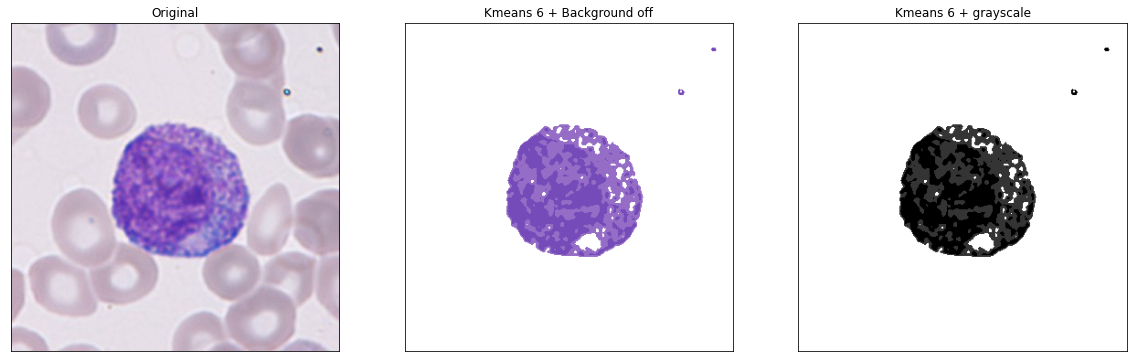

In [3]:
# On choisit K means K=6 pour avoir suffisamment de nuance de grix sur la cellule sélectionnée
# file = df[df.cell_type_code=='IG'].filename.values[100]
file='data\PBC_dataset_normal_DIB\ig\IG_761306.jpg'
img = cv2.imread(file,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# convert with Kmeans filters
img1, elapsed,centroids = KMeans_convert(img,n_clusters=6,bckgrd=False)

# convert in grayscale
rgb_weights = [1/3, 1/3, 1/3]
# rgb_weights = [0.2989, 0.5870, 0.1140]
img_gray = np.dot(img1[...,:3], rgb_weights)
# img2= img1.mean(axis=0)

plt.figure(figsize = (20, 10))

plt.subplot(1,3,1)
plt.imshow(img,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(img1,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('Kmeans 6 + Background off')

plt.subplot(1,3,3)
plt.imshow(img_gray,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('Kmeans 6 + grayscale')

plt.show()

## 3. Formation du dataset pour l'entrainement

Récupération des informations sur la base de données

In [4]:
path='data/PBC_dataset_normal_DIB/'
img_info = pd.read_csv(path + 'img_info.csv')
cell_types = pd.read_csv(path + 'cell_types.csv')
cell_types['cell_type3']=cell_types.cell_type_code + ' - ' + cell_types.cell_type2
# cell_types = cell_types[cell_types.Source=='article'].drop(columns=['Source'])
df = pd.merge(img_info,cell_types,how='outer') # merge on column cell_subtype
# display(df.head())

# nombre d'images:
print('nb d\'images:',len(df),'\n')
# distribution des types de cellules:
print(df.cell_type3.value_counts(normalize=True).round(4)*100)

nb d'images: 17094 

NE - neutrophils              19.48
EO - eosinophils              18.23
IG - immature granulocytes    16.94
PL - thrombocytes             13.74
ER - erythroblasts             9.07
MO - monocytes                 8.31
BA - basophils                 7.13
LY - lymphocytes               7.10
Name: cell_type3, dtype: float64


In [5]:
len(df.img_name.unique()) # les noms d'image sont bien uniques et peuvent être utilisés comme clé

17094

**Boucle sur un échantillon de la base de données**

On commence par définir une liste d'indices des lignes que nous allons traiter. On définit un nombre de cellules à traiter par catégorie, et on les sélectionne au hasard parmi la catégorie, puis une boucle traite chaque image et lui applique le filtre ci-dessus et stock la sortie dans une matrice data.

In [ ]:
npc=200 # nombre d'images par catégorie de cellule à scanner et filtrer

# On récupère les dimensions du format d'image le plus fréquent:
h=int(df.img_dim.mode()[0].split(' x ')[0])
w=int(df.img_dim.mode()[0].split(' x ')[1])

# Création d'une liste d'index à scanner dans le dataframe
cell_types = df.cell_type_code.value_counts().index # cell types sorted by number of apparitions in the dataset

# index selection:
selected_index=[]
for ct in cell_types: 
    all_index_ct=df[df.cell_type_code==ct].index
    new_selected_index=np.random.choice(all_index_ct, size=npc) # on en choisit npc par cell_type (npc= nombre de cellules)
    selected_index=np.concatenate([selected_index,new_selected_index]).astype(int)
    

# On process pour chacun de ces indexes:

data =[]

start = time.time()

# for i in df.index:
# for i in selected_index:

# tqdm pour la barre d'avancement
for i in tqdm(selected_index):

    p_start = time.time()
    
    filename =df.loc[i,'filename']
    img_height =df.loc[i,'img_height'] # hauteur de l'image
    img_width =df.loc[i,'img_width']
    
    # img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(filename,cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # on redimensionne l'image si elle n'est pas à la taille classique calculée ci-dessus
    if (img_height,img_width) != (h, w):
        # certaines images ne peuvent pas être redimensionnées d'où l'utilisation de try:
        try:
            img = cv2.resize(img, dsize = (h,w), interpolation = cv2.INTER_LINEAR)
        except Exception as e:
            print('impossible to reshape',filename,'for the following reason:\n',str(e))
            # on supprime ce fichier de notre base de données car nous ne pourrons pas l'intégrer à notre modèle:
            df=df[df.filename != filename]
            print('The image was deleted from database.')
    
    # convert with Kmeans filter
    img1, kmean_time ,centroids = KMeans_convert(img,n_clusters=6,bckgrd=False)

    # convert in grayscale
    rgb_weights = [1/3, 1/3, 1/3]  # [0.2989, 0.5870, 0.1140] => to play with gray shades
    img_gray = np.dot(img1[...,:3], rgb_weights)

    # convert in an array
    h,w=img_gray.shape
    X=img_gray.reshape(1,h*w)[0]
    
    # process time
    p_end = time.time()
    p_elapsed = p_end - p_start
    
    # label:
    img_name = [df.loc[i,'img_name']]
    process_time=[round(p_elapsed,6)]
    label = [df.loc[i,'cell_type3']]
    
    # store in data
    data.append(np.concatenate((img_name,process_time,label,X),axis=0))
    
    # print information on advancement
    # print(f'file processed : {filename}. Process time : {round(p_elapsed,2):0} s.')
    

end = time.time()
elapsed = end - start
print(f'Time elapsed : {elapsed//60 :0}min {round(elapsed % 60,0):0}sec')

 61%|██████    | 729/1200 [30:16<14:52,  1.90s/it]  

**Transformation de data en dataframe**

In [ ]:
col_names= np.concatenate( (['img_name','process_time','label'],['p'+str(i) for i in range(1,h*w+1)]),axis=0)
data_df=pd.DataFrame(data,columns = col_names)
data_df.label.value_counts()

**Sauvegarde en différents fichiers pickle (1 fichier par catégorie de cellule)**

In [ ]:
save_var_name = 'variables/data_kmeans1_sample200'
import pickle

start = time.time()

# On enregistre dans des pickle différents (enregistrer dans 1 seul pickle n'est pas possible)

cell_type_codes= data_df['label'].apply(lambda x: x.split(' - ')[0])
for ct in tqdm(cell_types):
    
    # on filtre sur le type de cellule et on enregistre in pickle
    # new_data = data_df[cell_type_codes==ct].iloc[:100,:]
    # new_data.to_pickle(save_var_name + '-' + ct+'1.pkl')
    # new_data = data_df[cell_type_codes==ct].iloc[100:,:]
    # new_data.to_pickle(save_var_name + '-' + ct+'2.pkl')
    
    new_data = data_df[cell_type_codes==ct]
    savename = save_var_name + '-' + ct+'.pkl'
    with open(savename, 'wb') as fp:
        pickle.dump(new_data, fp, protocol=4)

end = time.time()
elapsed = end - start
print(f'Time elapsed : {elapsed//60 :0}min {round(elapsed % 60,0):0}sec for {len(data_df):0} images, i.e. {round(len(data_df)/len(df)*100,2):0}% of the total dataset.')

**Sauvegarde sous la forme d'un csv**

On teste aussi la sauvegarde sous forme de csv : si ça peut marcher...!

*Avant la sauvegarde, on transpose la base de données car Excel ne supporte pas d'enregistrer autant de colonnes, alors que le nombre de lignes n'est pas limité*

In [ ]:
save_var_name = 'variables/data_kmeans1_sample200_2.csv'
(df.T).to_csv(save_var_name)
# (df.T).to_csv(save_var_name,index=False)